In [14]:
# Autor: Jairo Valea López
#
# Operaciones con distribuciones temporales de niebla en el
# marco del proyecto Niebla A-8 del GSJ.

# Importado de librerías habituales

import os
import math
import pandas as pd
import numpy as np
import scipy.stats as stats
import time
import matplotlib
import matplotlib.animation as animation
from IPython.utils import io
from natsort import natsorted
from IPython.display import HTML
from tqdm.notebook import tqdm, trange # barra de progreso
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib.artist import Artist
%matplotlib notebook

def promedio(lst):
    return sum(lst) / len(lst)

# cargado de datos (ensayos procesados)
# OBLIGATORIO

ruta_proces = 'C:\\Users\\miguel.anton\\Desktop\\NIEBLA\\Ensayos procesados\\'

carpeta = natsorted(os.listdir(ruta_proces))
procesados = []
nombres = []

dx = [0.007,0.008,0.009,0.009,0.01,0.011,0.011,0.012,0.013,0.014,0.015,0.016,0.018,0.019,0.02,0.022,0.024,0.025,0.027
,0.029,0.031,0.034,0.036,0.039,0.042,0.045,0.048,0.052,0.056,0.06,0.065,0.069,0.075,0.08,0.086,0.093,0.099,0.107,0.115
,0.123,0.133,0.143,0.153,0.165,0.177,0.19,0.204,0.22,0.236,0.254,0.272,0.293,0.315,0.338,0.363,0.39,0.42,0.451,0.484
,0.521,0.559,0.601,0.646,0.694,0.746,0.802,0.862,0.926,0.995,1.069,1.149,1.235,1.327]

for f in carpeta:
    name, ext = os.path.splitext(f)
    if ext == '.txt':
        procesados.append(pd.read_csv(ruta_proces + name + ext, delimiter = ",", decimal = "."))
        nombres.append(name + ext)

<IPython.core.display.Javascript object>


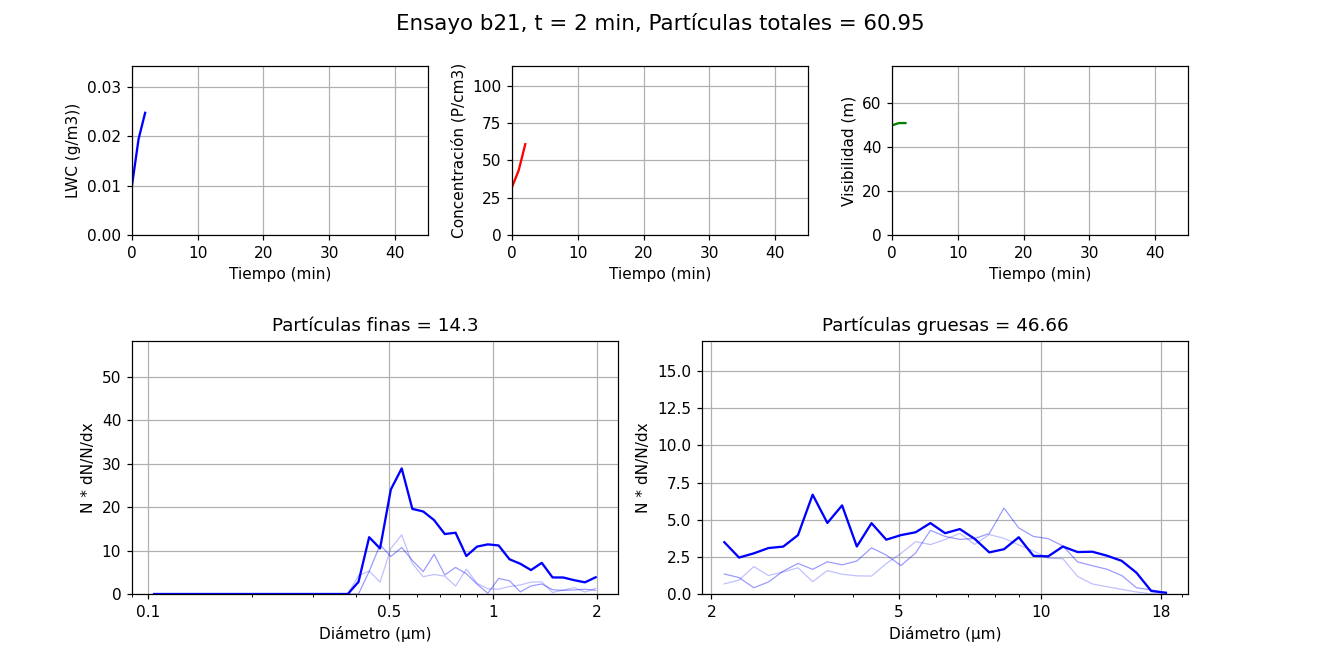

In [69]:
# GRÁFICOS 5 VARIABLES - HUMEDAD, CONCENTRACIÓN, VISIBILIDAD, FINOS, GRUESOS // SIN NORMALIZAR
# CON REGISTRO DE PRIMEROS 10 MIN DE NIEBLA
# INDIVIDUAL, AKA CAMPO DE PRUEBAS

j = 44  # cs02 = 59, cs04 = 61, ol01 = 63

ult_fil = procesados[0].shape[0]-1
ult_col = procesados[0].shape[1]-2
diams_f = procesados[0].iloc[ult_fil,3:45] # vectores con los tamaños de partícula (separados en finos y gruesos)
diams_g = procesados[0].iloc[ult_fil,45:ult_col]

fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(2, 6, height_ratios = [1, 1.5], width_ratios = [1,1,1,1,1,1])
ax1 = plt.subplot(gs[0,0:2])
ax2 = plt.subplot(gs[0,2:4])
ax3 = plt.subplot(gs[1,0:3])
ax4 = plt.subplot(gs[1,3:7])
ax5 = plt.subplot(gs[0,4:6])
#ax12 = ax1.twinx()
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.8,hspace=0.5)

ax1.set_xlabel('Tiempo (min)')
ax1.set_ylabel('LWC (g/m3))')
#ax12.set_ylabel('Visibilidad (m))')
ax2.set_xlabel('Tiempo (min)')
ax2.set_ylabel('Concentración (P/cm3)')
ax3.set_xlabel('Diámetro (µm)')
ax3.set_ylabel('N * dN/N/dx')
ax4.set_xlabel('Diámetro (µm)')
ax4.set_ylabel('N * dN/N/dx')
ax5.set_xlabel('Tiempo (min)')
ax5.set_ylabel('Visibilidad (m)')
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax4.grid(True)
ax5.grid(True)

ax1.set_xlim(0, len(procesados[j])-1)
ax1.set_ylim(0, max(procesados[j].iloc[:,1]))
ax2.set_xlim(0, len(procesados[j])-1)
ax2.set_ylim(0, max(procesados[j].iloc[:,2]))
ax5.set_xlim(0, len(procesados[j])-1)
ax5.set_ylim(0, max(procesados[j].iloc[:,76])+20)
#ax12.set_ylim(0, 200)

ult_fil = procesados[j].shape[0]-1
ult_col = procesados[j].shape[1]-2
suma_total = []
suma_gruesos = []
suma_finos = []
finos = np.array(procesados[j].iloc[0:ult_fil,3:45])
gruesos = np.array(procesados[j].iloc[0:ult_fil,45:ult_col])
for i in range(gruesos.shape[0]): # el mismo para ambos
    suma_gruesos.append(np.sum(gruesos[i,:]))
    suma_finos.append(np.sum(finos[i,:]))
    suma_total.append(suma_finos[i]+suma_gruesos[i])
densidad_finos = np.empty((finos.shape[0],finos.shape[1]))
densidad_gruesos = np.empty((gruesos.shape[0],gruesos.shape[1]))
for k in range(finos.shape[0]):
    for l in range(finos.shape[1]):
        densidad_finos[k,l] = (finos[k,l])*(1/dx[l])
    for m in range(gruesos.shape[1]):
        densidad_gruesos[k,m] = (gruesos[k,m])*(1/dx[m+finos.shape[1]])
maximo_f = np.max(densidad_finos)
maximo_g = np.max(densidad_gruesos)

ax3.set_ylim(0, maximo_f*1.1)
ax4.set_ylim(0, maximo_g*1.1)
ax3.set_xscale('log')
ax4.set_xscale('log')
ax3.set_xticks([0.1,0.5,1,2], minor=False)
labels3 = [0.1,0.5,1,2]
ax3.set_xticklabels(labels3)
ax4.set_xticks([2,5,10,18], minor=False)
labels4 = [2,5,10,18]
ax4.set_xticklabels(labels4)

lines = []
grafis = []
anots = []
mins = range(len(procesados[j])-1)
    
def animate(i):
    for line in lines:
        line.remove()
        del line
    lines[:] = []
    for line in grafis:
        line.remove()
        del line
    grafis[:] = []
    for text in anots:
        Artist.remove(text)
    anots[:] = []
    #ax5.clear()
    plt.suptitle("Ensayo " + nombres[j][6:-14] + ", t = " + str(i) + ' min, Partículas totales = ' + str(round(suma_total[i],2)), size = 14)
    ax3.set_title('Partículas finas = ' + str(round(suma_finos[i],2)))
    ax4.set_title('Partículas gruesas = ' + str(round(suma_gruesos[i],2)))
    # Anotaciones del % de niebla respecto a la original
    if (i > 9):
        pp1 = round(100*(suma_finos[i]/promedio(suma_finos[0:10])),1)
        anot1 = ax3.annotate('(' + str(pp1) + '% finos niebla original)', xy =(0.55,0.99*maximo_f), size = 9, backgroundcolor = 'white')
        anots.append(anot1)
        pp2 = round(100*(suma_gruesos[i]/promedio(suma_gruesos[0:10])),1)
        anot2 = ax4.annotate('(' + str(pp2) + '% gruesos niebla original)', xy =(6.5,0.99*maximo_g), size = 9, backgroundcolor = 'white')
        anots.append(anot2)
    # gráfico central (finos)
    line11, = ax3.plot(diams_f,densidad_finos[i],color = 'blue')
    lines.append(line11)
    if (i > 0):
        line21, = ax3.plot(diams_f,densidad_finos[i-1],color = 'blue', alpha = 0.4, linewidth = 0.8)
        lines.append(line21)
    if (i > 1):
        line31, = ax3.plot(diams_f,densidad_finos[i-2],color = 'blue', alpha = 0.25, linewidth = 0.8)
        lines.append(line31)
    if (i > 2):
        line41, = ax3.plot(diams_f,densidad_finos[i-3],color = 'blue', alpha = 0.1, linewidth = 0.8)
        lines.append(line41)
    if (nombres[j][6] != '8'):
        if (i > 9):
            line51, = ax3.plot(diams_f,promedio(densidad_finos[0:10]),color='red',alpha = 0.8, linewidth = 0.7)
            lines.append(line51)
    # gráfico inferior (gruesos)
    line21, = ax4.plot(diams_g,densidad_gruesos[i],color = 'blue')
    lines.append(line21)
    if (i > 0):
        line22, = ax4.plot(diams_g,densidad_gruesos[i-1],color = 'blue', alpha = 0.4, linewidth = 0.8)
        lines.append(line22)
    if (i > 1):
        line32, = ax4.plot(diams_g,densidad_gruesos[i-2],color = 'blue', alpha = 0.25, linewidth = 0.8)
        lines.append(line32)
    if (i > 2):
        line42, = ax4.plot(diams_g,densidad_gruesos[i-3],color = 'blue', alpha = 0.1, linewidth = 0.8)
        lines.append(line42)
    if (nombres[j][6] != '8'):
        if (i > 9):
            line52, = ax4.plot(diams_g,promedio(densidad_gruesos[0:10]),color='red',alpha = 0.8, linewidth = 0.7)
            lines.append(line52)
    # gráficos superiores
    graf1, = ax1.plot(mins[0:i+1], procesados[j].iloc[0:i+1,1], color = "blue", label = "LWC")
    grafis.append(graf1)
    graf2, = ax2.plot(mins[0:i+1], procesados[j].iloc[0:i+1,2], color = "red", label = "Concentración")
    grafis.append(graf2)
    graf5, = ax5.plot(mins[0:i+1], procesados[j].iloc[0:i+1,ult_col+1], color = "green", label = "Visibilidad")
    grafis.append(graf5)
    #ax5.scatter(procesados[j].iloc[0:i+1,1], procesados[j].iloc[0:i+1, ult_col + 1], color = "green")
        
ani = animation.FuncAnimation(fig, animate, frames = range(len(procesados[j])-1), interval=1000, blit=False)
ani.save(ruta_proces + nombres[j][0:-13] + 'video.mp4', writer = 'ffmpeg', bitrate = 8*8);

In [54]:
# GRÁFICOS 4 VARIABLES - HUMEDAD, CONCENTRACIÓN, FINOS, GRUESOS // SIN NORMALIZAR
# CON REGISTRO DE PRIMEROS 10 MIN DE NIEBLA

ult_fil = procesados[0].shape[0]-1
ult_col = procesados[0].shape[1]-2
diams_f = procesados[0].iloc[ult_fil,3:45] # vectores con los tamaños de partícula (separados en finos y gruesos)
diams_g = procesados[0].iloc[ult_fil,45:ult_col]

for j in trange(len(nombres)):
    with io.capture_output() as captured:
        fig = plt.figure(figsize=(8,9))
    gs = gridspec.GridSpec(3, 2, height_ratios = [1, 2, 2])
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])
    ax3 = plt.subplot(gs[1,:])
    ax4 = plt.subplot(gs[2,:])
    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)
    
    ax1.set_xlabel('Tiempo (min)')
    ax1.set_ylabel('LWC (g/m3))')
    ax2.set_xlabel('Tiempo (min)')
    ax2.set_ylabel('Concentración (P/cm3)')
    ax3.set_xlabel('Diámetro (µm)')
    ax3.set_ylabel('N * dN/N/dx')
    ax4.set_xlabel('Diámetro (µm)')
    ax4.set_ylabel('N * dN/N/dx')
    ax1.grid(True)
    ax2.grid(True)
    ax3.grid(True)
    ax4.grid(True)
    
    ax1.set_xlim(0, len(procesados[j])-1)
    ax1.set_ylim(0, max(procesados[j].iloc[:,1]))
    ax2.set_xlim(0, len(procesados[j])-1)
    ax2.set_ylim(0, max(procesados[j].iloc[:,2]))
    
    ult_fil = procesados[j].shape[0]-1
    ult_col = procesados[j].shape[1]-2
    suma_total = []
    suma_gruesos = []
    suma_finos = []
    finos = np.array(procesados[j].iloc[0:ult_fil,3:45])
    gruesos = np.array(procesados[j].iloc[0:ult_fil,45:ult_col])
    for i in range(gruesos.shape[0]): # el mismo para ambos
        suma_gruesos.append(np.sum(gruesos[i,:]))
        suma_finos.append(np.sum(finos[i,:]))
        suma_total.append(suma_finos[i]+suma_gruesos[i])
    densidad_finos = np.empty((finos.shape[0],finos.shape[1]))
    densidad_gruesos = np.empty((gruesos.shape[0],gruesos.shape[1]))
    for k in range(finos.shape[0]):
        for l in range(finos.shape[1]):
            densidad_finos[k,l] = (finos[k,l])*(1/dx[l])
        for m in range(gruesos.shape[1]):
            densidad_gruesos[k,m] = (gruesos[k,m])*(1/dx[m+finos.shape[1]])
    maximo_f = np.max(densidad_finos)
    maximo_g = np.max(densidad_gruesos)
    
    ax3.set_ylim(0, maximo_f*1.1)
    ax4.set_ylim(0, maximo_g*1.1)
    ax3.set_xscale('log')
    ax4.set_xscale('log')
    ax3.set_xticks([0.1,0.5,1,2], minor=False)
    labels3 = [0.1,0.5,1,2]
    ax3.set_xticklabels(labels3)
    ax4.set_xticks([2,5,10,18], minor=False)
    labels4 = [2,5,10,18]
    ax4.set_xticklabels(labels4)
    
    lines = []
    grafis = []
    anots = []
    mins = range(len(procesados[j])-1)
    
    def animate(i):
        for line in lines:
            line.remove()
            del line
        lines[:] = []
        for line in grafis:
            line.remove()
            del line
        grafis[:] = []
        for text in anots:
            Artist.remove(text)
        anots[:] = []
        plt.suptitle("Ensayo " + nombres[j][6:-14] + ", t = " + str(i) + ' min, Partículas totales = ' + str(round(suma_total[i],2)))
        ax3.set_title('Partículas finas = ' + str(round(suma_finos[i],2)))
        ax4.set_title('Partículas gruesas = ' + str(round(suma_gruesos[i],2)))
        # Anotaciones del % de niebla respecto a la original
        if (nombres[j][6] != '8'):
            if (i > 9):
                pp1 = round(100*(suma_finos[i]/promedio(suma_finos[0:10])),1)
                anot1 = ax3.annotate('(' + str(pp1) + '% finos niebla original)', xy =(0.8,0.99*maximo_f), size = 9, backgroundcolor = 'white')
                anots.append(anot1)
                pp2 = round(100*(suma_gruesos[i]/promedio(suma_gruesos[0:10])),1)
                anot2 = ax4.annotate('(' + str(pp2) + '% gruesos niebla original)', xy =(9,0.99*maximo_g), size = 9, backgroundcolor = 'white')
                anots.append(anot2)
        # gráfico central (finos)
        line11, = ax3.plot(diams_f,densidad_finos[i],color = 'blue')
        lines.append(line11)
        if (i > 0):
            line21, = ax3.plot(diams_f,densidad_finos[i-1],color = 'blue', alpha = 0.4, linewidth = 0.8)
            lines.append(line21)
        if (i > 1):
            line31, = ax3.plot(diams_f,densidad_finos[i-2],color = 'blue', alpha = 0.25, linewidth = 0.8)
            lines.append(line31)
        if (i > 2):
            line41, = ax3.plot(diams_f,densidad_finos[i-3],color = 'blue', alpha = 0.1, linewidth = 0.8)
            lines.append(line41)
        if (nombres[j][6] != '8'):
            if (i > 9):
                line51, = ax3.plot(diams_f,promedio(densidad_finos[0:10]),color='red',alpha = 0.8, linewidth = 0.7)
                lines.append(line51)
        # gráfico inferior (gruesos)
        line21, = ax4.plot(diams_g,densidad_gruesos[i],color = 'blue')
        lines.append(line21)
        if (i > 0):
            line22, = ax4.plot(diams_g,densidad_gruesos[i-1],color = 'blue', alpha = 0.4, linewidth = 0.8)
            lines.append(line22)
        if (i > 1):
            line32, = ax4.plot(diams_g,densidad_gruesos[i-2],color = 'blue', alpha = 0.25, linewidth = 0.8)
            lines.append(line32)
        if (i > 2):
            line42, = ax4.plot(diams_g,densidad_gruesos[i-3],color = 'blue', alpha = 0.1, linewidth = 0.8)
            lines.append(line42)
        if (nombres[j][6] != '8'):
            if (i > 9):
                line52, = ax4.plot(diams_g,promedio(densidad_gruesos[0:10]),color='red',alpha = 0.8, linewidth = 0.7)
                lines.append(line52)
        # gráficos superiores
        graf1, = ax1.plot(mins[0:i+1], procesados[j].iloc[0:i+1,1], color = "blue", label = "LWC")
        grafis.append(graf1)
        graf2, = ax2.plot(mins[0:i+1], procesados[j].iloc[0:i+1,2], color = "red", label = "Concentración")
        grafis.append(graf2)

    with io.capture_output() as captured:
        ani = animation.FuncAnimation(fig, animate, frames = range(len(procesados[j])-1), interval=1000, blit=False)
        ani.save(ruta_proces + nombres[j][0:-13] + 'video_4factores.mp4', writer = 'ffmpeg', bitrate = 8*8);

  0%|          | 0/65 [00:00<?, ?it/s]

In [14]:
# GRÁFICOS 4 VARIABLES - HUMEDAD, CONCENTRACIÓN, FINOS, GRUESOS // NORMALIZADOS

ult_fil = procesados[j].shape[0]-1
ult_col = procesados[j].shape[1]-2
diams_f = procesados[0].iloc[ult_fil,3:45] # vectores con los tamaños de partícula (separados en finos y gruesos)
diams_g = procesados[0].iloc[ult_fil,45:ult_col]

for j in trange(len(nombres)):
    with io.capture_output() as captured:
        fig = plt.figure(figsize=(8,9))
    gs = gridspec.GridSpec(3, 2, height_ratios = [1, 2, 2])
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])
    ax3 = plt.subplot(gs[1,:])
    ax4 = plt.subplot(gs[2,:])
    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)
    
    ax1.set_xlabel('Tiempo (min)')
    ax1.set_ylabel('Humedad (g/m3))')
    ax2.set_xlabel('Tiempo (min)')
    ax2.set_ylabel('Concentración (P/cm3)')
    ax3.set_xlabel('Diámetro (µm)')
    ax3.set_ylabel('Densidad')
    ax4.set_xlabel('Diámetro (µm)')
    ax4.set_ylabel('Densidad')    
    ax1.grid(True)
    ax2.grid(True)
    ax3.grid(True)
    ax4.grid(True)
    
    ax1.set_xlim(0, len(procesados[j])-1)
    ax1.set_ylim(0, max(procesados[j].iloc[:,1]))
    ax2.set_xlim(0, len(procesados[j])-1)
    ax2.set_ylim(0, max(procesados[j].iloc[:,2]))
    
    suma_total = []
    suma_gruesos = []
    suma_finos = []
    finos = np.array(procesados[j].iloc[0:ult_fil,3:45])
    gruesos = np.array(procesados[j].iloc[0:ult_fil,45:ult_col])
    for i in range(gruesos.shape[0]): # el mismo para ambos
        suma_gruesos.append(np.sum(gruesos[i,:]))
        suma_finos.append(np.sum(finos[i,:]))
        suma_total.append(suma_finos[i]+suma_gruesos[i])
    densidad_finos = np.empty((finos.shape[0],finos.shape[1]))
    densidad_gruesos = np.empty((gruesos.shape[0],gruesos.shape[1]))
    for k in range(finos.shape[0]):
        for l in range(finos.shape[1]):
            densidad_finos[k,l] = (1/suma_finos[k])*(finos[k,l])*(1/dx[l])
        for m in range(gruesos.shape[1]):
            densidad_gruesos[k,m] = (1/suma_gruesos[k])*(gruesos[k,m])*(1/dx[m+finos.shape[1]])
    maximo_f = np.max(densidad_finos)
    maximo_g = np.max(densidad_gruesos)
    
    ax3.set_ylim(0, maximo_f*1.1)
    ax4.set_ylim(0, maximo_g*1.1)
    ax3.set_xscale('log')
    ax4.set_xscale('log')
    ax3.set_xticks([0.1,0.5,1,2], minor=False)
    labels3 = [0.1,0.5,1,2]
    ax3.set_xticklabels(labels3)
    ax4.set_xticks([2,5,10,18], minor=False)
    labels4 = [2,5,10,18]
    ax4.set_xticklabels(labels4)
    
    lines = []
    grafis = []
    mins = range(len(procesados[j])-1)
    
    def animate(i):
        for line in lines:
            line.remove()
            del line
        lines[:] = []
        for line in grafis:
            line.remove()
            del line
        grafis[:] = []
        plt.suptitle("t = " + str(i) + ' min, Partículas totales = ' + str(round(suma_total[i],2)))
        ax4.set_title('Partículas gruesas = ' + str(round(suma_gruesos[i],2)))
        ax3.set_title('Partículas finas = ' + str(round(suma_finos[i],2)))
        # gráfico central (finos)
        line11, = ax3.plot(diams_f,densidad_finos[i],color = 'black')
        lines.append(line11)
        if (i > 0):
            line21, = ax3.plot(diams_f,densidad_finos[i-1],color = 'black', alpha = 0.4, linewidth = 0.8)
            lines.append(line21)
        if (i > 1):
            line31, = ax3.plot(diams_f,densidad_finos[i-2],color = 'black', alpha = 0.25, linewidth = 0.8)
            lines.append(line31)
        if (i > 2):
            line41, = ax3.plot(diams_f,densidad_finos[i-3],color = 'black', alpha = 0.1, linewidth = 0.8)
            lines.append(line41)    
        # gráfico inferior (gruesos)
        line21, = ax4.plot(diams_g,densidad_gruesos[i],color = 'black')
        lines.append(line21)
        if (i > 0):
            line22, = ax4.plot(diams_g,densidad_gruesos[i-1],color = 'black', alpha = 0.4, linewidth = 0.8)
            lines.append(line22)
        if (i > 1):
            line32, = ax4.plot(diams_g,densidad_gruesos[i-2],color = 'black', alpha = 0.25, linewidth = 0.8)
            lines.append(line32)
        if (i > 2):
            line42, = ax4.plot(diams_g,densidad_gruesos[i-3],color = 'black', alpha = 0.1, linewidth = 0.8)
            lines.append(line42)
        # gráficos superiores
        graf1, = ax1.plot(mins[0:i+1], procesados[j].iloc[0:i+1,1], color = "blue", label = "Humedad")
        grafis.append(graf1)
        graf2, = ax2.plot(mins[0:i+1], procesados[j].iloc[0:i+1,2], color = "red", label = "Concentración")
        grafis.append(graf2)

    with io.capture_output() as captured:
        ani = animation.FuncAnimation(fig, animate, frames = range(len(procesados[j])-1), interval=1000, blit=False)
        ani.save(ruta_proces + nombres[j][0:-13] + 'video_4factores_norm.mp4', writer = 'ffmpeg', bitrate = 8*8);

IndexError: single positional indexer is out-of-bounds

In [7]:
!jupyter nbconvert --to script distribucion_temporal.ipynb

[NbConvertApp] Converting notebook distribucion_temporal.ipynb to script
[NbConvertApp] Writing 13022 bytes to distribucion_temporal.py
